In [18]:
! python3 -m pip install -U tensorflow==2.0.0a0 > /dev/null

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Perceptron using SKLearn

Single layer perceptron is a linear classifier. I can't solve the XOR problem. Stacking multiple single layer Perceptrons can solve the XOR problem

In [19]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int) # 0 is setosa

perceptron_classifier = Perceptron()
perceptron_classifier.fit(X, y)
y_pred = perceptron_classifier.predict(X)

# How many predictions are correct?
print((y == y_pred).sum())
# How many datapoints are in the dataset
print(len(y))

150
150


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


# Multilayer Perceptron


MLPs became computatinally feasable with the introduction of the [backpropagatino](https://scholar.google.com/scholar?q=Learning+Internal+Representations+by+Error+Propagation+author%3Arumelhart) algorithm, which is still in use. Using backpropagation the gradients of the error with respect to each of the parameters of the MLP are calculated, and then gradienct descent can be applied to learn the parameters iteratively. See [this article](https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a) for a simple explanation of Gradient Descent, and Stochastic Gradient Descent.

## Regression

In general, when building MLPs for regression, we don't use activation functions in the output layer. The loss function to use during training is typically the **mean squared error**, but if you have a lot of outliers in the training set, you may prefer to use the **mean absolute error instead**. 

## Classification

For binary classification or multiple binary labels we use a single output neuron with Logistic activation function. For Multiclass classification (single prediction of mutually exclusive classes), we generally use softmax. In all cases cross entropy is used as the loss function.

# Implementing MLPs using Keras

Keras is a high-level Deep Learning API that allows you to easily build, train, evaluate, and execute all sorts of neural networks. Checkout [https://keras.io](https://keras.io) for more information. Let's start with an image classification example:

In [20]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.0.0-alpha0'

In [21]:
# let's add some code to have each job emit logs in a particular location
import os
root_logdir = os.path.join(os.curdir, "ml_logs")

def get_run_logidr():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [22]:
# This dataset contains greyscale images 28 x 28 of clothing items
fashion_mnist = keras.datasets.fashion_mnist
# Only train/test datasets
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print("Full train dataset shape", X_train_full.shape)
print("Train dataset dtype", X_train_full.dtype)

# Lets split train_full into train and validation. Use 5000 samples for validation 
# and 55000 for training. We also scale pixel greyscale values to [0,1]
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Define the name of each of the possible target values
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Full train dataset shape (60000, 28, 28)
Train dataset dtype uint8


In [23]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# Get a summary of the network
model.summary()
# Access an individual layer
input_layer = model.layers[1]
print(input_layer.name)

# Get layer parameters. For Dense layers this include weights and bias
w, b = input_layer.get_weights()
print(w, b)

# Now let's define the learning parameters
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=0.001),
             metrics=["accuracy"])

# And train
history = model.fit(X_train, y_train, batch_size=50,
                    epochs=30, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.TensorBoard(get_run_logidr())])

# Finally save the model
model.save("dense_classification_mlp.h5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_17 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
dense_16
[[ 0.02954233  0.00875533 -0.07251536 ...  0.02019174  0.00941438
   0.04226395]
 [ 0.06194845  0.01317564 -0.04560491 ...  0.07142855 -0.03805353
   0.06074245]
 [ 0.02188134  0.00097659  0.02470022 ...  0.01895747 -0.06135573
  -0.0309

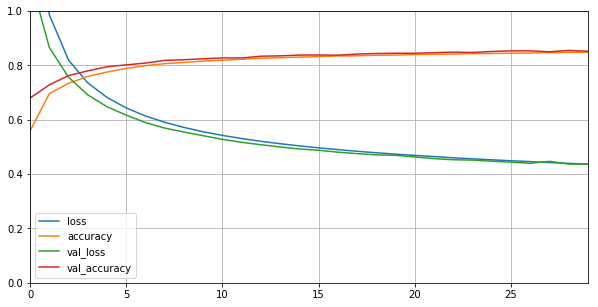

In [24]:
# Let's plot the history
import pandas as pd
import matplotlib.pyplot as plt

def draw_history(history):
    pd.DataFrame(history.history).plot(figsize=(10, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
draw_history(history)

In [25]:
# Let's see how the model perform on the test dataset
model.evaluate(X_test, y_test)

# We can finally use the model to obtain predictinos
y_proba = model.predict(X_test[:10])
print(y_proba.round(2))

# We can ask Keras to retrieve the highest probability class for us
y_pred = model.predict_classes(X_test[:10])
np.array(class_names)[y_pred]

10000/10000 [==============================] - 0s 42us/sample - loss: 77.3760 - accuracy: 0.8028
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sneaker', 'Sneaker'], dtype='<U11')

Let's build a Regression example:

In [26]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

# Partition the full dataset into train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target)
# Partition the train dataset into train/validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full)

# Preprocess the training data using the StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# define the network
model = keras.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(optimizer="sgd", loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid),
                   callbacks=[keras.callbacks.TensorBoard(get_run_logidr())])

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 48us/sample - loss: 1.7294 - val_loss: 0.9951
Epoch 2/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.8735 - val_loss: 0.8058
Epoch 3/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.7690 - val_loss: 0.7388
Epoch 4/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.7180 - val_loss: 0.6945
Epoch 5/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6790 - val_loss: 0.6577
Epoch 6/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6478 - val_loss: 0.6283
Epoch 7/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6199 - val_loss: 0.6037
Epoch 8/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5968 - val_loss: 0.5816
Epoch 9/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5769 - val_l

In [27]:
# Let's evaluate the model on the test dataset, and perform som inference
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)
print(y_pred)
for i in range(3):
    print(y_pred[i] - y_test[i])

5160/5160 [==============================] - 0s 17us/sample - loss: 0.4927
[[1.9602997 ]
 [0.81674665]
 [2.3321047 ]]
[0.57029974]
[-0.47125334]
[0.8991047]


# Keras Functional API

The [Keras functional API](https://keras.io/getting-started/functional-api-guide/) is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

Let's define a model that feeds the inputs through a deep path, and directly to the output:

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 53us/sample - loss: 1.7352 - val_loss: 0.7187
Epoch 2/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.6741 - val_loss: 0.6328
Epoch 3/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.6247 - val_loss: 0.5989
Epoch 4/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5968 - val_loss: 0.5750
Epoch 5/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5764 - val_loss: 0.5568
Epoch 6/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5595 - val_loss: 0.5411
Epoch 7/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5460 - val_loss: 0.5292
Epoch 8/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5346 - val_loss: 0.5189
Epoch 9/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5253 - val_l

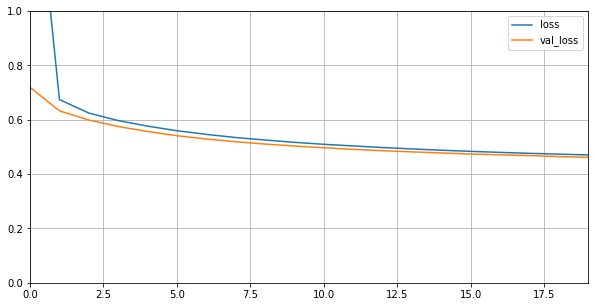

In [28]:
# Shape is [rows, cols], and we only need the columns to define the input
in_0 = keras.layers.Input(shape=X_train.shape[1:])
h1 = keras.layers.Dense(30, activation="relu")(in_0)
h2 = keras.layers.Dense(30, activation="relu")(h1)
concat = keras.layers.Concatenate()([in_0, h2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[in_0], outputs=[output])

model.compile(optimizer="sgd", loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid),
                   callbacks=[keras.callbacks.TensorBoard(get_run_logidr())])
draw_history(history)

Using the functional API a model can have multiple inputs and outputs. For instance, we may use multiple inputs when we want to send a certain range of the input throught the dense path, while sending the rest directly to the output. Rages can overlap. The following code defines such network:

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 54us/sample - loss: 2.1754 - val_loss: 1.0041
Epoch 2/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.8552 - val_loss: 0.7621
Epoch 3/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.7328 - val_loss: 0.6910
Epoch 4/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.6802 - val_loss: 0.6477
Epoch 5/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.6432 - val_loss: 0.6155
Epoch 6/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.6138 - val_loss: 0.5876
Epoch 7/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5897 - val_loss: 0.5665
Epoch 8/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5692 - val_loss: 0.5480
Epoch 9/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5519 - val_l

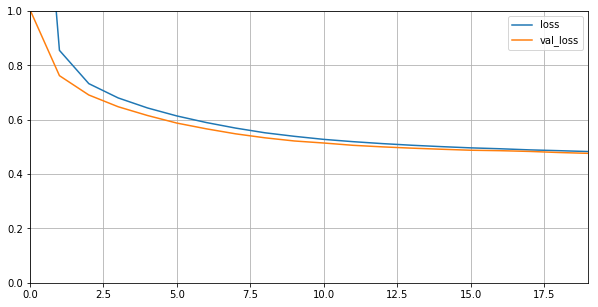

In [29]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

# in order to call this model, we have to pass multiple inputs
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid),
                    callbacks=[keras.callbacks.TensorBoard(get_run_logidr())])
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))
draw_history(history)

**Multiple outputs are also possible**. One of the multiple uses of multiple outputs is **regularization**; we may want to add auxiliary outputs in the architecture to ensure that parts of the network learn something useful, not only the _final_ output. 

Each output needs it own loss function, so we must pass a list of loss functions when compiling the network. To train the network we need to pass labels for each output as well. When we evaluate we obtain the total loss and the individual losses. A network with multiple outputs will predict multiple values.

# Callbacks

The ```fit()``` method accept **callbacks** that will be called at different times, for example at the end of each epoch, or at the end of the training. Callbacks can be used to saved model checkpoints:

In [30]:
# Only train/test datasets
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
# Lets split train_full into train and validation. Use 5000 samples for validation 
# and 55000 for training. We also scale pixel greyscale values to [0,1]
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# Now let's define the learning parameters
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=0.001),
             metrics=["accuracy"])

checkpoint_cb = keras.callbacks.ModelCheckpoint("model_checkpoint.h5",
                                               save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, keras.callbacks.TensorBoard(get_run_logidr())])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 84us/sample - loss: 1.4063 - accuracy: 0.6027 - val_loss: 0.9472 - val_accuracy: 0.7186
Epoch 2/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.8379 - accuracy: 0.7328 - val_loss: 0.7408 - val_accuracy: 0.7664
Epoch 3/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.7075 - accuracy: 0.7697 - val_loss: 0.6554 - val_accuracy: 0.7890
Epoch 4/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.6420 - accuracy: 0.7910 - val_loss: 0.6043 - val_accuracy: 0.8034
Epoch 5/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.5989 - accuracy: 0.8027 - val_loss: 0.5713 - val_accuracy: 0.8158
Epoch 6/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.5686 - accuracy: 0.8117 - val_loss: 0.5451 - val_accuracy: 0.8258
Epoch 7/10
55000/55000 [==============================] -

Keras provides many callbacks, and we can create our own ones by implementing ```keras.callbacks.Callback```. The base class defines many lifecycle event handlers that we can override:

In [31]:
class PrintUsefullDataCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

# Tensorboard

In SageMaker if tensorboard is started as:
```
/home/ec2-user/anaconda3/envs/tensorflow_p27/bin/tensorboard --port=6006 --logdir ./ml_logs/
```

You can connect to it using the following URL (with your own notebook prefix):

```
https://mlclassic-benchmark.notebook.us-west-2.sagemaker.aws/proxy/6006/
```